In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
np.set_printoptions(4,suppress=True)

In [2]:
def cv2_imshow(imgz, title=None, cmap='gray'):
    plt.imshow(imgz, cmap=cmap)
    if title is not None:
        plt.title(title)
    plt.show()

im shape: (542, 962)
im dim: 2


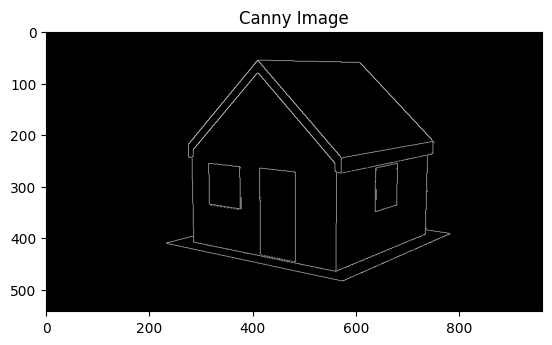

In [3]:
image = cv2.imread("canny_result.png", 0)
print("im shape:",image.shape)
print("im dim:",image.ndim)
cv2_imshow(image, "Canny Image")

In [4]:
# APPLY HOUGH TRANSFORM
# threshold is the upper value of our double thresholding step
def hough_line(input_img, step=1, range_t = (-90, 90), threshold=100):
    
    # Get Dimensions of image and populate theta range
    width, height = input_img.shape
    theta_range = np.deg2rad(np.arange(range_t[0], range_t[1], step))
    
    # A**2 + B**2 = C**2
    csqaured = int(round(math.sqrt(width * width + height * height)))
    
    # Define possible rho space
    rhos = np.linspace(-csqaured, csqaured, csqaured * 2)
    nr_thetas = len(theta_range)

    # Hough accumulator array of theta vs rho
    acc = np.zeros((2 * csqaured, nr_thetas), dtype=np.uint8)

    # Get binary list of edges (True and False)
    are_edges = input_img > threshold

    # Retrieve indexes in which the value is True (thus a white line is present)
    y_index, x_index = np.nonzero(are_edges)

    # Accumulator Vote Procedure
    for y,x in zip(y_index,x_index):
        for t_id, t_val in enumerate(theta_range):
            rho = csqaured + int(round(x * np.cos(t_val) + y * np.sin(t_val)))
            acc[rho, t_id] += 1

    return acc, theta_range, rhos


def display_hough(accumulator, thetas, rhos, cmap='hot'):
    plt.figure(figsize=(10, 10))
    plt.xlim(-90, 90)
    print("ACCUMULATOR")
    plt.imshow(accumulator, extent=[np.rad2deg(thetas[-1]), np.rad2deg(thetas[0]), rhos[-1], rhos[0]], cmap=cmap, aspect="auto")

ACCUMULATOR


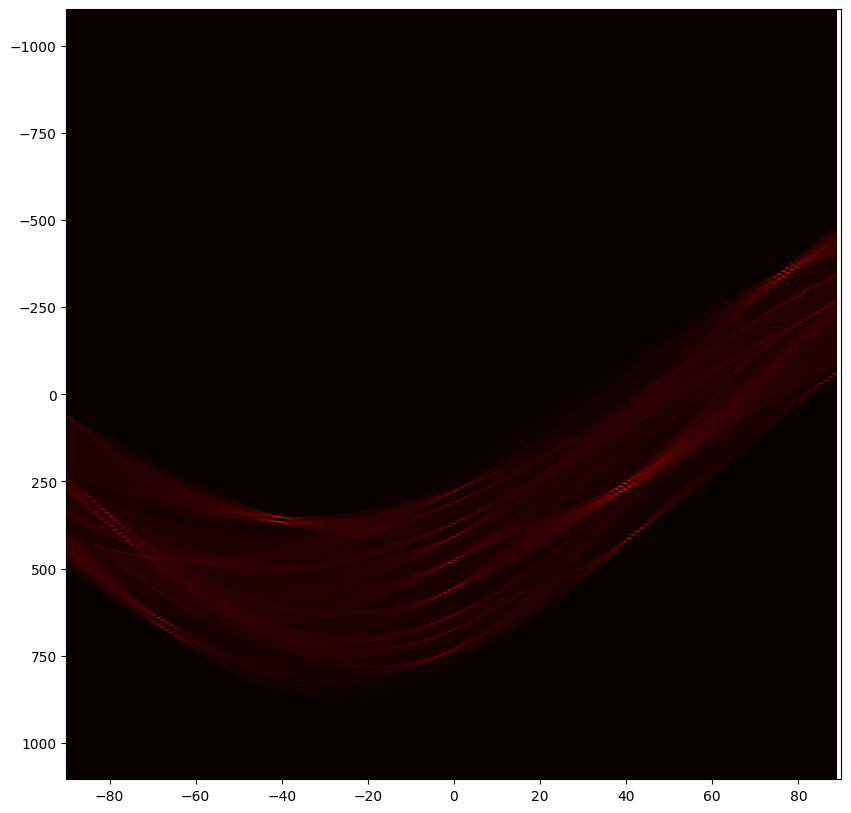

In [5]:
accumulator, thetas, rhos = hough_line(image)
display_hough(accumulator= accumulator, thetas=thetas, rhos= rhos, cmap='hot')

In [6]:
#Detect lines ------------------------------------------------------
def select_lines(_acc, thetas, rhos, threshold_percentage=0.5, up_theta=None, down_theta=None, line_length=1100):
    # Threshold the accumulator to identify the most voted lines
    max_val = np.max(_acc)
    threshold = threshold_percentage * max_val # % of max val =  threshold
    maximas = np.argwhere(_acc > threshold)
    detected_lines = []

    for elem in maximas:
        rho = round(rhos[elem[0]],2) # retrieve from rhos peak index to actual rho value
        theta = round(thetas[elem[1]],2) # retrieve from theta peak index to actual theta value

        if up_theta is not None and down_theta is not None:
            if theta * 180/np.pi > up_theta or theta * 180/np.pi < down_theta:
                continue

        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho

        x1 = int(x0 + line_length * -b)
        y1 = int(y0 + line_length * a)
        x2 = int(x0 - line_length * -b)
        y2 = int(y0 - line_length * a)
        detected_lines.append([(x1, y1), (x2, y2)])

    title_string = 'Image with: ' + str(len(detected_lines)) +  ' detected lines: ' +  str(up_theta) + \
            ' > t > ' + str(down_theta) + ' ,and threshold at ' + str(threshold_percentage)

    return detected_lines, title_string

def plot_lines(_image, _lines, title):
    picture = np.copy(_image)
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.imshow(image, cmap="gray")
    ax.set_ylim((image.shape[0], 0))
    ax.set_axis_off()


    for idx, line in enumerate(_lines):
        p0, p1 = line
        col = (np.random.random(), np.random.random(), np.random.random())
        ax.plot((p0[0], p1[0]), (p0[1], p1[1]), label=idx, color=col)


    plt.legend()
    ax.set_xlim((0, picture.shape[1]))
    ax.set_ylim((picture.shape[0], 0))
    ax.set_title(title)
    plt.show()

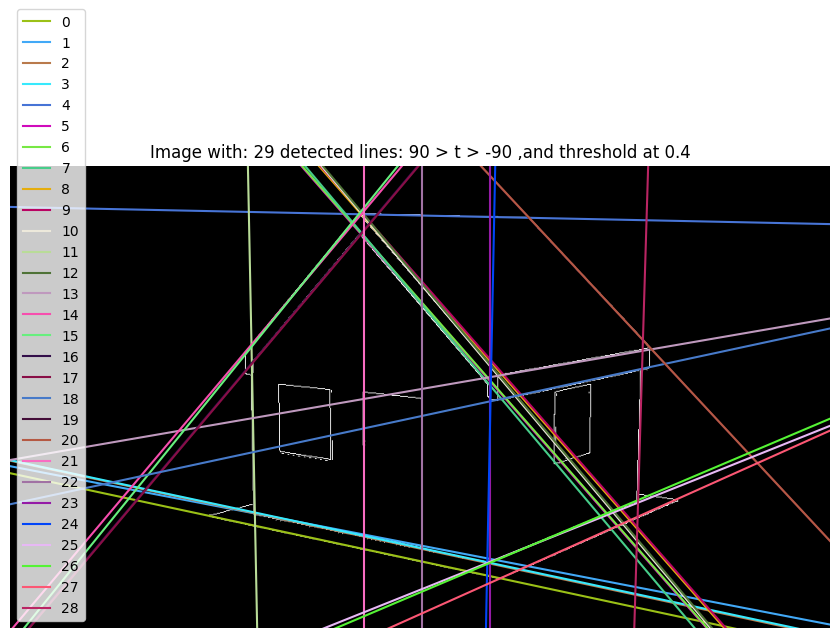

In [7]:
# Examples
lines, img_title = select_lines(accumulator, thetas, rhos, 0.4, up_theta=90, down_theta=-90)
plot_lines(image,lines,img_title)



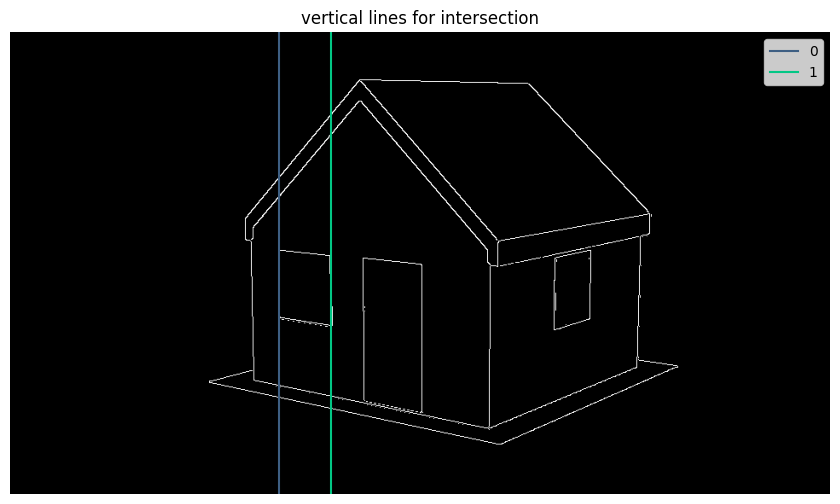

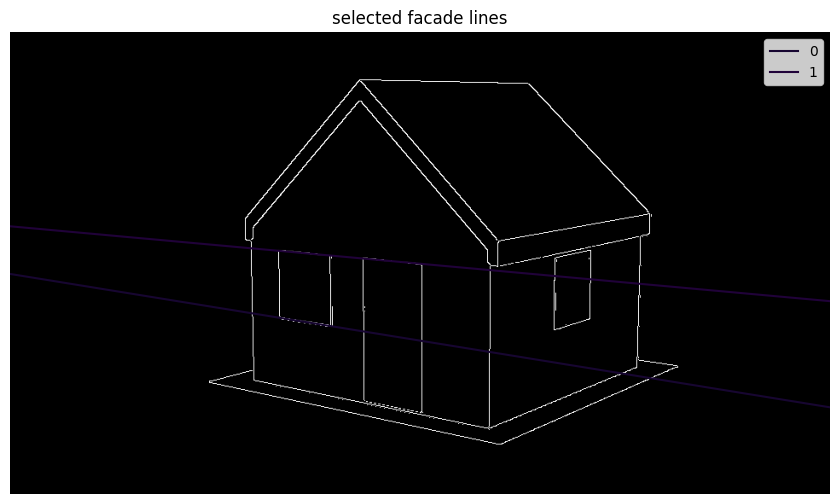

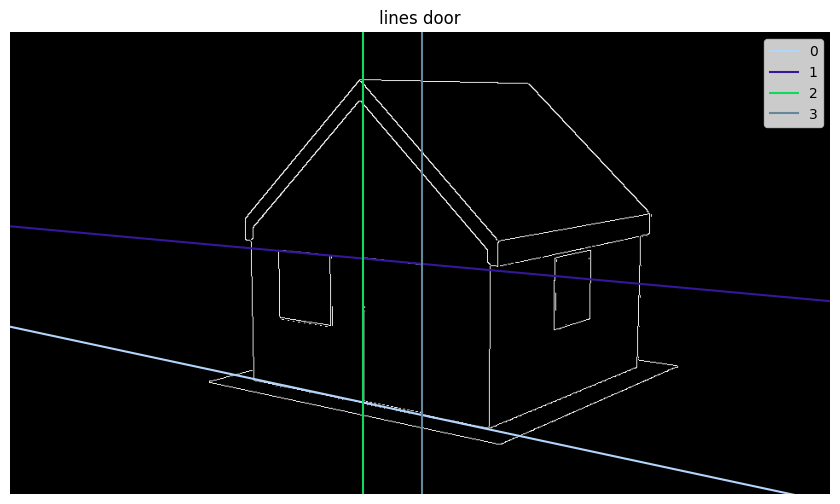

In [8]:
# Window Line extraction -----------------------------
# Vertical Line Extraction
lines_vertical_intersection, _ = select_lines(accumulator, thetas, rhos, threshold_percentage=0.25, up_theta=10, down_theta=-10)
wall_vertical_lines = [lines_vertical_intersection[2],lines_vertical_intersection[20]]
lines_vertical_intersection = lines_vertical_intersection[5:7]
plot_lines(image,lines_vertical_intersection,"vertical lines for intersection")

# Horizontal Line Extraction
lines_window, _ = select_lines(accumulator, thetas, rhos, threshold_percentage=0.25, up_theta=-80, down_theta=-85)
lines_window = lines_window[1:]
plot_lines(image,lines_window,"selected facade lines")

# Door Line Extraction -----------------------------
lines_door_ver, _ = select_lines(accumulator, thetas, rhos, threshold_percentage=0.25, up_theta=10, down_theta=-10)
lines_door_ver = [lines_door_ver[9], lines_door_ver[14]]
lines_door_hor, _ = select_lines(accumulator, thetas, rhos, threshold_percentage=0.25, up_theta=-77, down_theta=-85)
lines_door_hor = [lines_door_hor[7], lines_door_hor[10]]
lines_door = lines_door_hor + lines_door_ver
plot_lines(image,lines_door,"lines door")

In [9]:
# Intersection between two lines
def get_intersection_points(set_line1, set_line2):
    inter_points = []
    for line1 in set_line1:
        for line2 in set_line2:
            inter_points.append(get_intersection(line2, line1))
    return inter_points

# Given two lines, get the x and y intersection
# Source used: https://stackoverflow.com/questions/20677795/how-do-i-compute-the-intersection-point-of-two-lines
def get_intersection(line1, line2):

    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    # Cramers Rule
    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y


In [10]:
# Apply Bi-linear interpolation to map the points from our orginal image under the Matrix H (here A) and an affine transformation T
def apply_inv_map(A, _image, T):
    A1 = np.copy(_image)
    # Get height and width of source image
    M1 = A1.shape[0]
    N1 = A1.shape[1]

    # Set height and width of target image
    M2 = M1
    N2 = N1
    A2 = np.zeros((M2,N2))

    # Set default intensity to white
    A2[:,:] = 255

    #A = np.matmul(T,A)
    #A = np.identity(n=3)
    A = np.linalg.inv(A)
    #print(H*A)

    #Transformation with inverse mapping and bilinear interpolation
    for i in range(0,M2):
        for j in range(0,N2):
            # coordinates of the (i,j)-th pixel in A2
            x = i + 0.5
            y = j + 0.5

            # convert to homogeneous coordinates
            p = np.array([x,y,1])
            # transform with matrix A
            q = np.matmul(A,p)

            # coordinates in A1
            x = q[0]/q[-1]
            y = q[1]/q[-1]

            # bilinear interpolation
            k = round(x) - 1
            l = round(y) - 1
            u = x - k - 0.5
            v = y - l - 0.5
            if (k >= 0) and (k < M1-1) and (l >= 0) and (l < N1-1):
                A2[i,j] = round( (1-v) * ( (1-u)*A1[k,l] + u*A1[k+1,l] ) +
                                 v * ( (1-u)*A1[k,l+1] + u*A1[k+1,l+1] ) )

    return A2

Vanishing line
[-0.0001  0.001   1.    ]


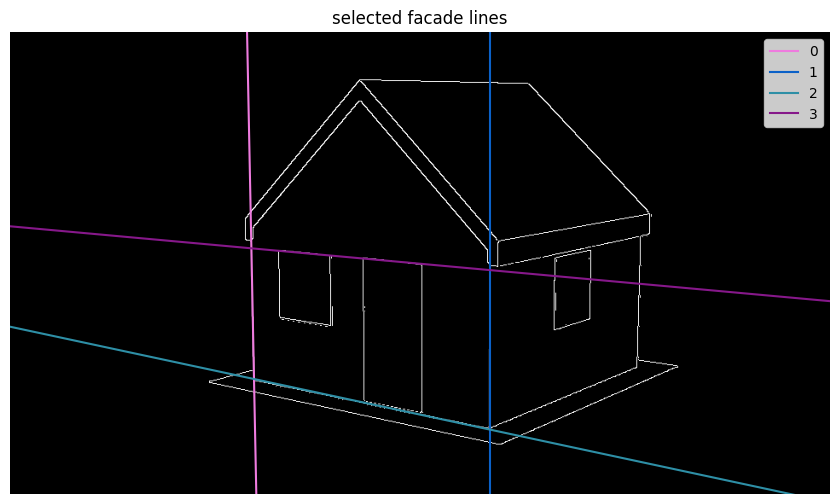

In [11]:
# Computation of Vanishing Line:

line1,line2 = wall_vertical_lines

# Horizontal Lines -------------------------------------
# Bottom line points
p1 = np.array([line1[0][1],line1[0][0],1])
p2 = np.array([line1[1][1],line1[1][0],1])

# Top line points
p3 = np.array([line2[0][1],line2[0][0],1])
p4 = np.array([line2[1][1],line2[1][0],1])

line3, line4 = lines_door_hor

# Left line points
p5 = np.array([line3[0][1],line3[0][0],1])
p6 = np.array([line3[1][1],line3[1][0],1])

# Right line points
p7 = np.array([line4[0][1],line4[0][0],1])
p8 = np.array([line4[1][1],line4[1][0],1])

# LINES
l1 = np.cross(p1,p2)
l1 = l1/l1[2]

l2 = np.cross(p3,p4)
l2 = l2/l2[2]

l3 = np.cross(p5,p6)
l3 = l3/l3[2]
l4 = np.cross(p7,p8)
l4 = l4/l4[2]

# Intersection
c1 = np.cross(l1,l2)
c1 = c1/c1[2]
c2 = np.cross(l3,l4)
c2 = c2/c2[2]

# Our vanishing point should be the line at infinity but due to the perspective distortion it is not
# So we can call it also line not infinity
vanishing_line = np.cross(c1,c2)
vanishing_line = vanishing_line/vanishing_line[2]

print("Vanishing line")
print(vanishing_line)

plot_lines(image,wall_vertical_lines+lines_door_hor,"selected facade lines")




[-0.0001  0.001   1.    ]
[[ 1.      0.      0.    ]
 [ 0.      1.      0.    ]
 [-0.0001  0.001   1.    ]]


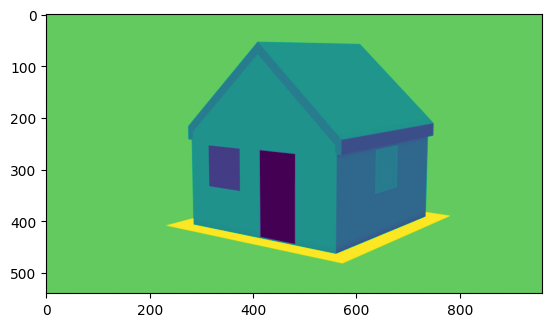

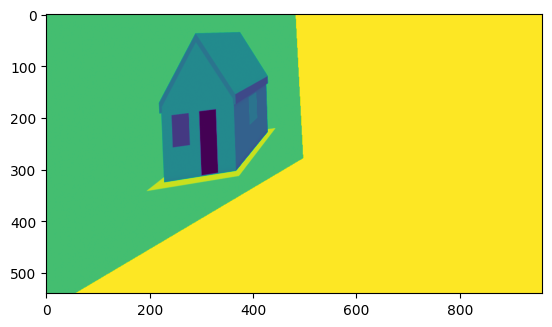

In [12]:

l1,l2,l3 = vanishing_line
print(vanishing_line)

H = np.array([[1,   0,  0],
              [0,   1,  0],
              [l1, l2, l3]])

print(H)

t = -3.8*np.pi/180
T = np.array(
    [[np.cos(t),-np.sin(t),0],
     [np.sin(t),np.cos(t),0],
     [0, 0, 1]])

S = np.array(
    [[1,0,0],
     [0,1,0],
     [0, 0, 1]])

# T = np.matmul(T, S)

# T = np.array(
#     [[1.5,0,0],
#      [0,1.5,0],
#      [0, 0, 1]])


house = cv2.imread("house1.png", 0)
plt.imshow(house)
plt.show()
rectified = apply_inv_map(H, _image=house, T=S)

plt.imshow(rectified)
plt.show()

In [13]:
# def plot_points(image, points):
#     fig, ax = plt.subplots()
#     ax.imshow(image, cmap="gray")
#     for i, point in enumerate(points):
#         col = (np.random.random(), np.random.random(), np.random.random())
#         ax.scatter(point[0],point[1],color=col, label=i, marker='.')
#         plt.text(point[0],point[1], s=i, color='red', size= 'medium')
#     #plt.legend()
#     plt.show()

In [14]:
# #POINTS FOR AREA ESTIMATION
# vertical_window = lines_vertical_intersection
# horizontal_window = lines_window
# window_p = get_intersection_points(horizontal_window, vertical_window)
#
# vertical_door = lines_door_ver
# horizontal_door = lines_door_hor
# door_p = get_intersection_points(horizontal_door, vertical_door)
#
# # FOR SIMPLICITY, ADD DOOR POINTS LATER ONCE RECTIFICATION OF POINTS IS GOOD
# points = window_p
#
# rectified_p = []
# for p in points:
#     p_temp = np.array([p[0], p[1], 1])
#     print(10*"-")
#     print(p_temp)
#
#     p_rect = p_temp @ H
#     p_rect /= p_rect[-1]
#     p_rect = p_rect[:2]
#
#     print(p_rect)
#     rectified_p.append(p_rect)
#
# plot_points(house, points)
# plot_points(rectified, rectified_p)
#


## Counting Window Pixels In original Image

Center Value intensity: 63


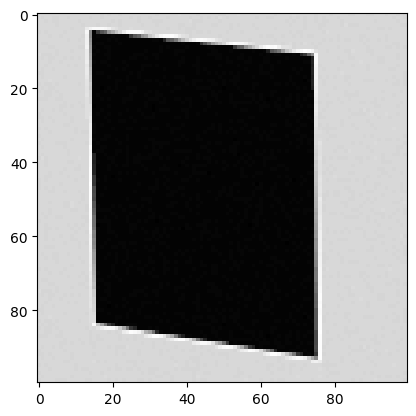

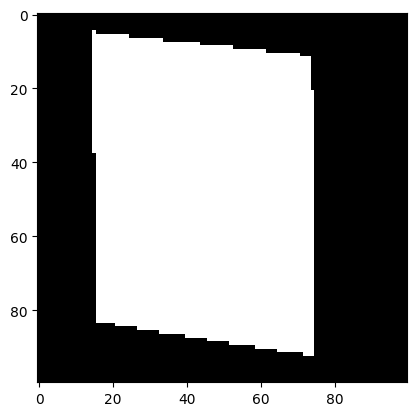

total window pixels in non rectified: 4725


In [15]:
window_img = house[250:350,300:400]

print("Center Value intensity:", window_img[50][50])

base = np.zeros(window_img.shape)
og_px_count = 0
for y in range(window_img.shape[0]):
    for x in range(window_img.shape[1]):
        if 60 < window_img[y][x] < 65:
            og_px_count +=1
            base[y][x] = 100

cv2_imshow(window_img)
cv2_imshow(base)

print("total window pixels in non rectified:",og_px_count)



## Counting Window Pixels In rectified Image

Center Value intensity: 64.0


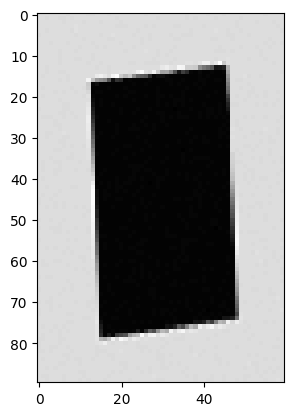

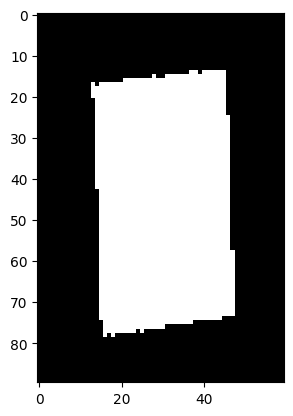

total window pixels in rectified: 1988


In [16]:
window_img2 = rectified[180:270,230:290]

# Center Value intensity
print("Center Value intensity:", window_img2[25][30])

base2 = np.zeros(window_img2.shape)
rec_px_count = 0
for y in range(window_img2.shape[0]):
    for x in range(window_img2.shape[1]):
        if 60 < window_img2[y][x] < 65:
            rec_px_count +=1
            base2[y][x] = 100

cv2_imshow(window_img2)
cv2_imshow(base2)

print("total window pixels in rectified:",rec_px_count)



## Counting Door Pixels In rectified Image

26.0


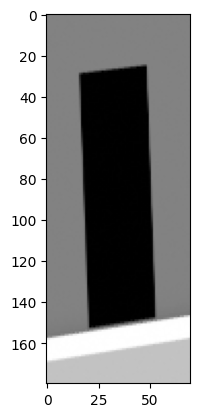

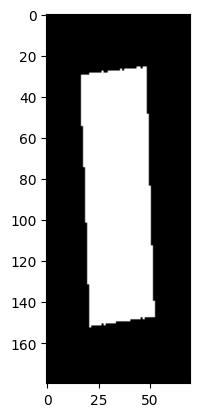

total door pixels in rectified: 3885


In [17]:
door_img = rectified[160:340,280:350]

#center value intensity
print(door_img[40][35])

base3 = np.zeros(door_img.shape)
door_px = 0
for y in range(door_img.shape[0]):
    for x in range(door_img.shape[1]):
        if 20 < door_img[y][x] < 30:
            door_px +=1
            base3[y][x] = 100

cv2_imshow(door_img)
cv2_imshow(base3)

print("total door pixels in rectified:",door_px)


In [18]:
print("Window original pixel count:", og_px_count, " vs rectified amount:", rec_px_count)
print("Rectified door pixel count:", door_px, " vs window rectified amount:", rec_px_count)
print("Door area estimate:", round(door_px/rec_px_count, 2), "m squared")

Window original pixel count: 4725  vs rectified amount: 1988
Rectified door pixel count: 3885  vs rectified amount: 1988
Door area estimate: 1.95 m squared
